# Beginner's Guide: Gridding a Spectral Cube with VisCube 

In this tutorial, we will be using VisCube to grid a spectral cube. For simplicity, this tutorial skips the somewhat arduous process of extracting data from Measurement Sets into memory/numpy (for how to do that using CASA or XRADIO, see [here](https://viscube.readthedocs.io/en/latest/extracting_ms_to_py.html)). This tutorial focuses on JUST VisCube's gridding abilities themselves. For simplicity, we will be doing UV gridding (assuming the array is planar, so no W coordinates, a reasonable assumption for e.g. ALMA). 

##### To demonstrate VisRead's power, we will be calculating the gridded visibilities AND the associated standard deviations for a spectral cube of galaxy NGC4697!

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from viscube import grid_cube_all_stats, load_and_mask, hermitian_augment
import numpy as np

### Step 0: Load the numpy file previously extracted from the measurement set 

#### N.B., this tutorial assumes this numpy file has already been created for you.

To learn how to create such a numpy file for your measurement sets, see [here](https://viscube.readthedocs.io/en/latest/extracting_ms_to_py.html).

To download this npz file and run this notebook, go here: [link to Zenodo](https://zenodo.org/records/18263951)

In [18]:
path = "/home/darthbarth/Data/ngc_4697/NGC4697_visibilities.npz"
data = np.load(path)
freq = data["frequencies"]
u_raw = data["uu"]
v_raw = data["vv"]
vis_raw = data["data"]
weight_raw = data["weight"]
mask = data["mask"]

### Step 1: Apply the mask

In [19]:
frequencies, u0, v0, vis0, weight0 = load_and_mask(freq, u_raw, v_raw, vis_raw, weight_raw, mask)

### Step 2: Hermitian Augmentation

N.B., if you're working with a continuum dataset (whose shape is `(N_vis)` rather than `(N_freq, N_vis))`, you will need to add a `[None, N_vis]` dimension in order for the gridder to handle things properly (it needs a frequency dimension even if the number of channels is one). 

In [ ]:
uu, vv, vis_re, vis_imag, wt = hermitian_augment(u0, v0, vis0, weight0)
#For continuum data only:
#uu = uu[None, :]
#vv = vv[None, :]
#vis_re = vis_re[None, :]
#vis_imag = vis_imag[None, :]
#wt = wt[None, :]

### Step 3: Gridding with uncertainty estimation!

In this example, we use VisCube's `grid_cube_all_stats` function, which assumes you want to do UV gridding for a spectral cube and calculate the standard deviation within each grid cell. Other gridding functions in VisCube exist, e.g. `grid_cube_all_stats_wbinned`, which does UVW gridding instead. 

The outputs are as follows:

`mean_re`: the gridded visibilities, real component

`mean_im`: the gridded visibilities, imaginary component

`std_re`: standard deviations, per grid cell, of the real components of the gridded visibilities

`std_im`: standard deviations, per grid cell, of the imaginary components of the gridded visibilities

`counts`: number of visibilities in each grid cell (can be useful for creating a mask also)

`u_edges, v_edges`: the edges of the grid in U,V coordinates

In [7]:
mean_re, mean_im, std_re, std_im, counts, u_edges, v_edges = grid_cube_all_stats(
    frequencies=freq, uu=uu, vv=vv, vis_re=vis_re, vis_imag=vis_imag, weight=wt,
    npix = 501, window_name="kaiser_bessel",
    window_kwargs={"m": 6},   # only KB will use beta; m/normalize optional
)

100%|█| 83/83 [02:43<00:00,  1.97s/channel, coarse_std_im=332, coarse_std_re=332


### Step 4 (OPTIONAL): Visualize the results as a "dirty image" velocity map using SuperMAGE

For documentation on how to use SuperMAGE, please see here: https://supermage.readthedocs.io/en/latest/intro.html.

In [10]:
from supermage.utils.plotting import dirty_cube_tool, velocity_map
from supermage.utils.doppler_velocities import create_velocity_grid_stable
fov_arcseconds = 206265*501/(2*461206.80374266725)
num_pixels_uv = 501
arcseconds_per_pixel = fov_arcseconds / num_pixels_uv
freq_path = "/home/darthbarth/Data/ngc_4697/frequencies_correct.npy"
max_freq_index = 74
freq = (np.load(freq_path)/1e9)[:max_freq_index]
systemic_velocity = 1239.9591200072425
velocities_absolute, _ = create_velocity_grid_stable(freq[0], freq[-1], len(freq))
velocities = velocities_absolute.numpy() - systemic_velocity

# Define the region of interest for the cube (pixels 1000 to 1050)
roi_start, roi_end = 225, 276
fov_pixels = roi_end - roi_start
dirty_cube = dirty_cube_tool(mean_re, mean_im, roi_start, roi_end)
extent = (-1*arcseconds_per_pixel*fov_pixels/2, arcseconds_per_pixel*fov_pixels/2, -1*arcseconds_per_pixel*fov_pixels/2, arcseconds_per_pixel*fov_pixels/2)

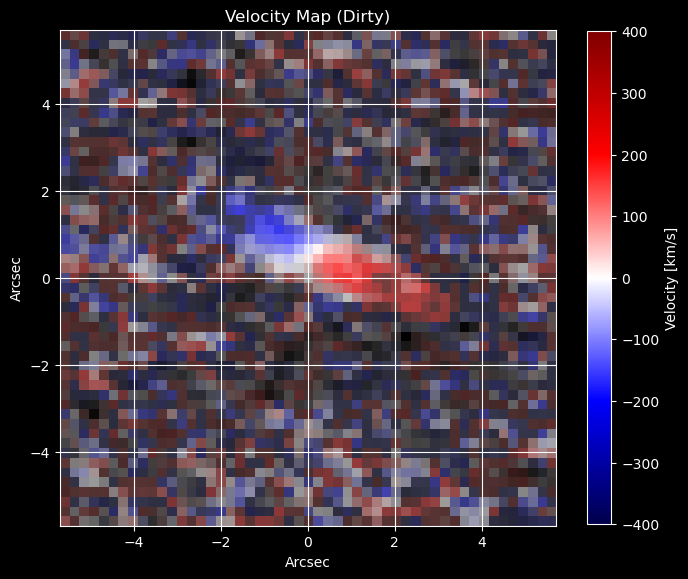

In [14]:
vel_map = velocity_map(dirty_cube[:, :, :max_freq_index], velocities)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors

plt.style.use('dark_background')
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.set_aspect('equal', adjustable='box')

divnorm=colors.TwoSlopeNorm(vcenter=0., vmin = -400, vmax = 400)
im11 = ax1.imshow(vel_map, cmap = "seismic", norm = divnorm, origin = "lower",  extent=extent)
c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black, c_white],256)
im12 = ax1.imshow(np.sum(dirty_cube[:, :, :max_freq_index], axis = 2), cmap = cmap_rb, origin = "lower",  extent=extent)

fig.colorbar(im11, label = "Velocity [km/s]", shrink = 0.8)
ax1.set_xlabel("Arcsec")
ax1.set_ylabel("Arcsec")
ax1.set_title("Velocity Map (Dirty)")
plt.grid()
plt.show()

### Step -1: Don't forget to save your results to disk!

In [15]:
save_dir1 = "/home/darthbarth/Data/ngc_4697/NGC4697_kaiser_bessel/gridded_visibilities_viscube1.npz"
np.savez(
        save_dir1,
        vis_bin_re   = mean_re,
        vis_bin_imag = mean_im,
        std_bin_re   = std_re,
        std_bin_imag = std_im,
        mask         = counts > 0,
    )